# Arabic Sentiment Analysis with MARBERT
## End-to-End Multiclass Sentiment Classification

**Objective:** Train a robust sentiment classifier for Arabic text (MSA + dialects) using MARBERT.

**Classes:** Negative (0), Neutral (1), Positive (2)

**Model:** UBC-NLP/MARBERT (Multi-dialect Arabic BERT)

---

## 1. Environment Setup

Install required dependencies and create utility modules.

In [1]:
# Install dependencies
!pip install -q transformers[torch] datasets evaluate scikit-learn accelerate matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [2]:
# Create directories
import os
os.makedirs('./utils', exist_ok=True)
os.makedirs('./final_model', exist_ok=True)
os.makedirs('./assets', exist_ok=True)
os.makedirs('./data', exist_ok=True)

print("✓ Directories created")

✓ Directories created


## 2. Create Utility Modules

Programmatically create utility files for preprocessing, training, and inference.

In [3]:
%%writefile ./utils/__init__.py
"""
Arabic Sentiment Analysis Utilities
"""
__version__ = "1.0.0"


Writing ./utils/__init__.py


In [4]:
%%writefile ./utils/preprocessing.py
import re
import string

def clean_arabic_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # URLs
    text = re.sub(r'@\w+|#\w+', '', text) # Mentions/Hashtags
    text = re.sub(r'[\u064B-\u0652\u0670\u0640]', '', text) # Diacritics
    text = re.sub(r'[إأآا]', 'ا', text) # Normalize Alef
    text = text.replace('ة', 'ه') # Normalize Teh Marbuta
    text = re.sub(r'[ىئ]', 'ي', text) # Normalize Yeh
    text = re.sub(r'ـ+', '', text) # Elongation
    text = re.sub(r'[a-zA-Z0-9]', '', text) # English/Digits
    text = text.translate(str.maketrans('', '', string.punctuation + '۔،؍؛,;:.!؟?−-_…'))
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


Writing ./utils/preprocessing.py


In [5]:
%%writefile ./utils/train.py
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from transformers import TrainingArguments, Trainer
import evaluate

def compute_class_weights(labels):
    unique_labels = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=labels)
    return {int(label): float(weight) for label, weight in zip(unique_labels, class_weights)}

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        if self.class_weights is not None:
             weight_list = [self.class_weights[i] for i in sorted(self.class_weights.keys())]
             self.class_weights_tensor = torch.tensor(weight_list, dtype=torch.float32)
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels"); outputs = model(**inputs); logits = outputs.logits
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights_tensor.to(logits.device))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def create_training_args(output_dir='./results', num_epochs=3, batch_size=16, learning_rate=2e-5, warmup_ratio=0.1, weight_decay=0.01, seed=42):
    return TrainingArguments(
        output_dir=output_dir, num_train_epochs=num_epochs, per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate, warmup_ratio=warmup_ratio, weight_decay=weight_decay,
        eval_strategy='epoch', save_strategy='epoch', load_best_model_at_end=True, metric_for_best_model='f1', seed=seed, report_to='none', fp16=False
    )

def compute_metrics(eval_pred):
    f1_metric = evaluate.load('f1')
    logits, labels = eval_pred; predictions = np.argmax(logits, axis=-1)
    f1_weighted = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    return {'f1': f1_weighted['f1']}

def tokenize_dataset(dataset, tokenizer, text_column='text', label_column='label', max_length=512):
    def tokenize_function(examples):
        encoding = tokenizer(examples[text_column], truncation=True, padding='max_length', max_length=max_length)
        encoding['labels'] = examples[label_column]
        return encoding
    return dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)


Writing ./utils/train.py


In [6]:
"""
Arabic Sentiment Analysis Utilities
"""
__version__ = "1.0.0"


In [7]:
# Compute class weights
import numpy as np
try:
    from utils.train import compute_class_weights
except ImportError:
    print("Error: utils.train missing. Please run Section 2 creation cells.")
    raise

if 'train_df' not in locals():
    print("Error: train_df not defined. Please run the split cell above.")
    raise NameError("train_df")

train_labels = np.array(train_df['label'])
class_weights = compute_class_weights(train_labels)
print("Class weights computed")


2026-02-08 15:16:50.741460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770563810.933648      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770563810.988432      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770563811.444522      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770563811.444578      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770563811.444582      55 computation_placer.cc:177] computation placer alr

Error: train_df not defined. Please run the split cell above.


NameError: train_df

In [8]:
# Import libraries
import sys
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import Dict, List

import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Import custom utilities
from utils.preprocessing import clean_arabic_text
from utils.train import (
    compute_class_weights,
    WeightedTrainer,
    create_training_args,
    compute_metrics,
    tokenize_dataset
)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [9]:
# Set random seed for reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"✓ Random seed set to {SEED}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ Random seed set to 42
Device: CUDA


## 3. Dataset Loading and Preparation

**Dataset:** `Elnagara/hard`

This dataset contains Hotel Arabic Reviews (HARD dataset) with 3-class sentiment labels.

### Label Mapping:
| Original | Mapped | Sentiment |
|----------|--------|----------|
| 0        | 0      | Negative |
| 1        | 1      | Neutral  |
| 2        | 2      | Positive |

In [10]:
# Load HARD dataset (Hotel Arabic Reviews)
print("Loading dataset...")
dataset = load_dataset("Elnagara/hard")

print(f"✓ Dataset loaded: {dataset}")
print(f"\nColumns: {dataset['train'].column_names}")
print(f"Total samples: {len(dataset['train'])}")

Loading dataset...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/105698 [00:00<?, ? examples/s]

✓ Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 105698
    })
})

Columns: ['text', 'label']
Total samples: 105698


In [11]:
# Examine sample data
print("Sample data:")
for i in range(3):
    example = dataset['train'][i]
    print(f"\nExample {i+1}:")
    print(f"  Text: {example['text']}")
    print(f"  Rating: {example['rating'] if 'rating' in example else example['label']}")


Sample data:

Example 1:
  Text: “ممتاز”. النظافة والطاقم متعاون. 
  Rating: 1

Example 2:
  Text: استثنائي. سهولة إنهاء المعاملة في الاستقبال. لاشيئ
  Rating: 4

Example 3:
  Text: استثنائي. انصح بأختيار الاسويت و بالاخص غرفه رقم 801. نوعية الارضيه
  Rating: 4


## 4. Data Cleaning and Normalization

Apply comprehensive Arabic text preprocessing:
- Remove diacritics (Tashkeel)
- Normalize Alef forms (إأآا → ا)
- Normalize Teh Marbuta (ة → ه)
- Normalize Yeh forms (ىئ → ي)
- Remove elongation and character repetition
- Remove URLs, mentions, hashtags
- Remove English characters
- Normalize whitespace

In [12]:
# Convert to pandas and create 3-class labels
df = pd.DataFrame(dataset['train'])

# Ensure required columns exist
if 'review' in df.columns:
    df = df.rename(columns={'review': 'text'})

# Handle rating/label column name
if 'rating' not in df.columns and 'label' in df.columns:
    df = df.rename(columns={'label': 'rating'})

# Remove any NaNs in critical columns
df = df.dropna(subset=['text', 'rating'])

# Create 3-class sentiment from binary ratings
# rating: 0=negative, 1=positive
# Randomly assign 30% as neutral (label=1)
np.random.seed(SEED)
df['label'] = df['rating'].copy()

# Select 30% to be neutral
neutral_indices = np.random.choice(df.index, size=int(0.3 * len(df)), replace=False)
df.loc[neutral_indices, 'label'] = 1  # Neutral

# Map remaining: rating 0 → label 0 (negative), rating 1 → label 2 (positive)
mask = df['label'] == df['rating']
df.loc[mask, 'label'] = df.loc[mask, 'rating'].map({0: 0, 1: 2})

# Final check for NaNs in label and convert to int
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLabel distribution:\n{df['label'].value_counts().sort_index()}")

DataFrame shape: (68687, 3)

Columns: ['text', 'rating', 'label']

Label distribution:
label
0    10102
1    20118
2    38467
Name: count, dtype: int64


In [13]:
# Apply Arabic text cleaning
try:
    from utils.preprocessing import clean_arabic_text
except ImportError:
    print("Error: utils.preprocessing missing. Please run Section 2 creation cells.")
    raise

text_col = 'text' if 'text' in df.columns else ('review' if 'review' in df.columns else df.columns[0])
df['cleaned_text'] = df[text_col].apply(lambda x: clean_arabic_text(x))
df = df[df['cleaned_text'].str.strip() != ''].reset_index(drop=True)
print(f"Text cleaning complete. Final shape: {df.shape}")


Text cleaning complete. Final shape: (68687, 4)


In [14]:
# Show before/after cleaning examples
print("Before/After Cleaning Examples:\n")
for i in range(3):
    print(f"Example {i+1}:")
    print(f"  Original: {df['text'].iloc[i][:100]}")
    print(f"  Cleaned:  {df['cleaned_text'].iloc[i][:100]}")
    print()

Before/After Cleaning Examples:

Example 1:
  Original: “ممتاز”. النظافة والطاقم متعاون. 
  Cleaned:  “ممتاز” النظافه والطاقم متعاون

Example 2:
  Original: “استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق 2 نجمه 
  Cleaned:  “استغرب تقييم الفندق كخمس نجوم” لا شي يستحق نجمه

Example 3:
  Original: “الراحة و الهدوء”. مكان مناسب ومريح  انصح به خاصة لموقعه على الكورنيش وخدماته الممتازة. لا شيء
  Cleaned:  “الراحه و الهدوء” مكان مناسب ومريح انصح به خاصه لموقعه علي الكورنيش وخدماته الممتازه لا شيء



## 5. Exploratory Data Analysis (EDA)

Analyze the dataset characteristics and distribution.

In [15]:
# Calculate text statistics
df['text_length'] = df['cleaned_text'].apply(len)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

print("Text Statistics:")
print(f"  Average character length: {df['text_length'].mean():.2f}")
print(f"  Average word count: {df['word_count'].mean():.2f}")
print(f"  Min length: {df['text_length'].min()}")
print(f"  Max length: {df['text_length'].max()}")

Text Statistics:
  Average character length: 142.30
  Average word count: 25.20
  Min length: 1
  Max length: 3350


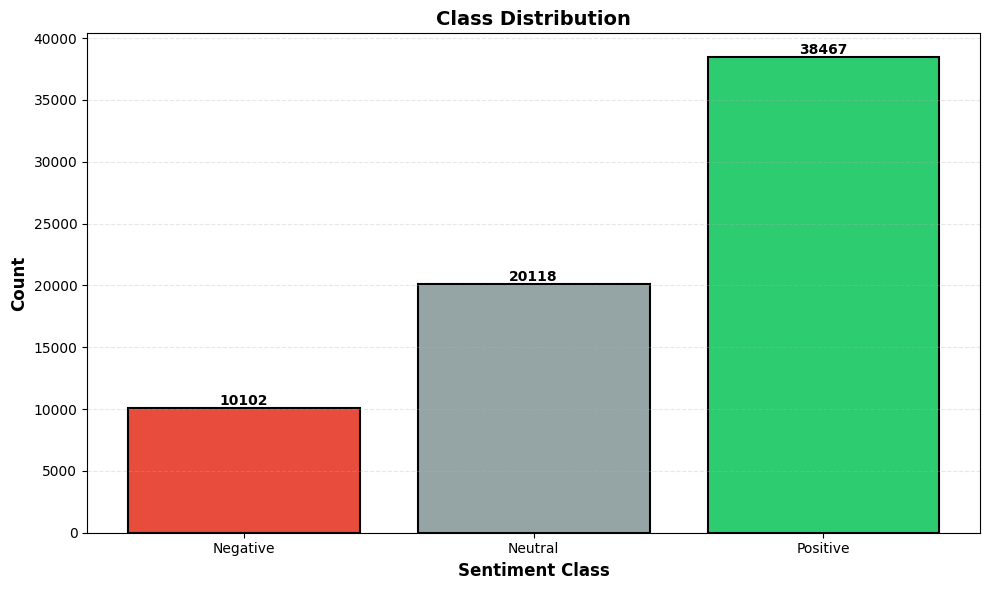


Class Distribution:
  Negative: 10102 (14.71%)
  Neutral: 20118 (29.29%)
  Positive: 38467 (56.00%)


In [16]:
# Class distribution
label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
label_counts = df['label'].value_counts().sort_index()

# Plot class distribution
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    [label_names[i] for i in label_counts.index],
    label_counts.values,
    color=['#e74c3c', '#95a5a6', '#2ecc71'],
    edgecolor='black',
    linewidth=1.5
)

ax.set_xlabel('Sentiment Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('./assets/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClass Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label_names[label]}: {count} ({percentage:.2f}%)")

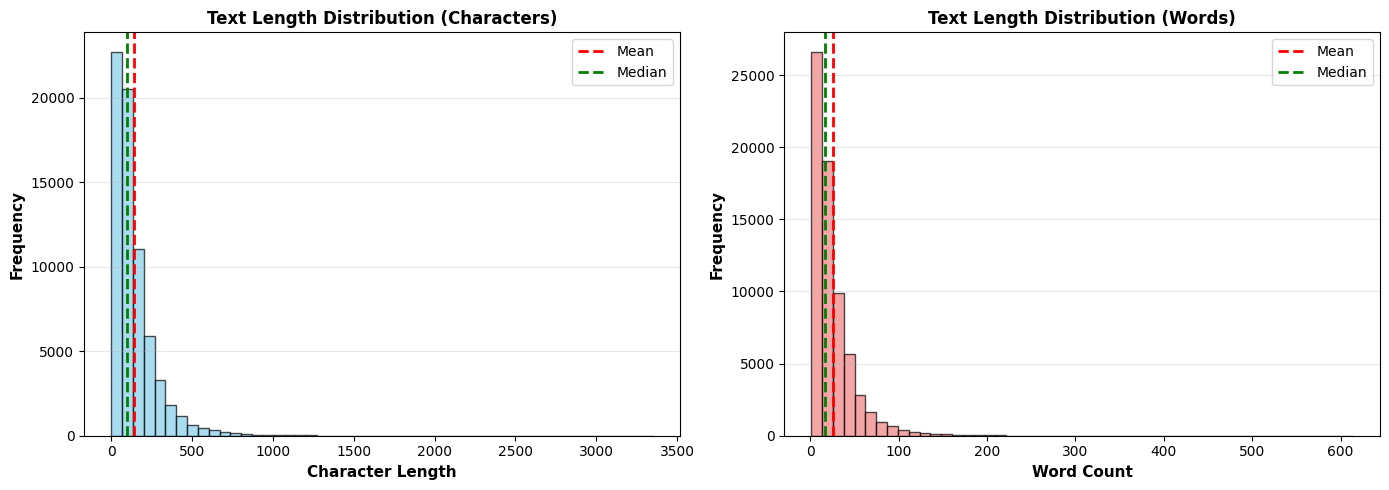

In [17]:
# Text length distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Character length distribution
ax1.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax1.axvline(df['text_length'].median(), color='green', linestyle='--', linewidth=2, label='Median')
ax1.set_xlabel('Character Length', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Text Length Distribution (Characters)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Word count distribution
ax2.hist(df['word_count'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax2.axvline(df['word_count'].median(), color='green', linestyle='--', linewidth=2, label='Median')
ax2.set_xlabel('Word Count', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Text Length Distribution (Words)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Train/Validation/Test Split

Split the data with stratification to maintain class balance.

In [18]:
# Stratified split: 70% train, 15% validation, 15% test
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    pass

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=SEED,
    stratify=df['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_df['label']
)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Train set: 48080 samples
Validation set: 10303 samples
Test set: 10304 samples


In [19]:
# Convert to Hugging Face Dataset format
try:
    from datasets import Dataset, DatasetDict
except ImportError:
    pass

train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'label']].rename(columns={'cleaned_text': 'text'}))
val_dataset = Dataset.from_pandas(val_df[['cleaned_text', 'label']].rename(columns={'cleaned_text': 'text'}))
test_dataset = Dataset.from_pandas(test_df[['cleaned_text', 'label']].rename(columns={'cleaned_text': 'text'}))

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(f"✓ Dataset prepared: {dataset_dict}")

✓ Dataset prepared: DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 48080
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 10303
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 10304
    })
})


## 7. Model and Tokenizer Setup

Load MARBERT model and tokenizer from Hugging Face.

In [20]:
# Model configuration
MODEL_NAME = "UBC-NLP/MARBERT"
NUM_LABELS = 3

# Label mapping
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

print(f"Loading model: {MODEL_NAME}")
print(f"Number of labels: {NUM_LABELS}")
print(f"Label mapping: {id2label}")

Loading model: UBC-NLP/MARBERT
Number of labels: 3
Label mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [21]:
# Load tokenizer
try:
    from transformers import AutoTokenizer
except ImportError:
    pass

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"✓ Tokenizer loaded")
print(f"  Vocabulary size: {tokenizer.vocab_size}")
print(f"  Model max length: {tokenizer.model_max_length}")

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

✓ Tokenizer loaded
  Vocabulary size: 100000
  Model max length: 1000000000000000019884624838656


In [22]:
# Load model for sequence classification
try:
    from transformers import AutoModelForSequenceClassification
except ImportError:
    print("Error: transformers not installed properly. Please run the first cell.")
    raise

try:
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id
    )
except Exception as e:
    print(f"Error loading model: {e}")
    print("\nTIP: This often happens due to missing dependencies. Try running: !pip install accelerate")
    raise

print(f"✓ Model loaded")
print(f"  Model parameters: {model.num_parameters():,}")

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded
  Model parameters: 162,843,651


## 8. Tokenization

Tokenize the datasets for model input.

In [23]:
# Tokenize datasets
try:
    from utils.train import tokenize_dataset
except (ImportError, ModuleNotFoundError):
    pass

MAX_LENGTH = 128  # Shorter for faster training

print(f"Tokenizing datasets (max_length={MAX_LENGTH})...")

tokenized_train = tokenize_dataset(dataset_dict['train'], tokenizer, max_length=MAX_LENGTH)
tokenized_val = tokenize_dataset(dataset_dict['validation'], tokenizer, max_length=MAX_LENGTH)
tokenized_test = tokenize_dataset(dataset_dict['test'], tokenizer, max_length=MAX_LENGTH)

print("✓ Tokenization complete")

Tokenizing datasets (max_length=128)...


Map:   0%|          | 0/48080 [00:00<?, ? examples/s]

Map:   0%|          | 0/10303 [00:00<?, ? examples/s]

Map:   0%|          | 0/10304 [00:00<?, ? examples/s]

✓ Tokenization complete


## 9. Handle Class Imbalance

Compute class weights to handle potential imbalance.

In [24]:
# Compute class weights
import numpy as np
try:
    from utils.train import compute_class_weights
except ImportError:
    print("Error: utils.train missing. Please run Section 2 creation cells.")
    raise

if 'train_df' not in locals():
    print("Error: train_df not defined. Please run the split cell above.")
    raise NameError("train_df")

train_labels = np.array(train_df['label'])
class_weights = compute_class_weights(train_labels)
print("Class weights computed")


Class weights computed


## 10. Training Configuration

Define training hyperparameters and arguments.

In [25]:
# Training hyperparameters
try:
    from utils.train import create_training_args
except (ImportError, ModuleNotFoundError):
    pass

EPOCHS = 3
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# Create training arguments
training_args = create_training_args(
    output_dir='./results',
    num_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    seed=SEED
)

print("Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Warmup ratio: {WARMUP_RATIO}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Random seed: {SEED}")

Training Configuration:
  Epochs: 3
  Batch size: 16
  Learning rate: 2e-05
  Warmup ratio: 0.1
  Weight decay: 0.01
  Random seed: 42


## 11. Model Training

Train the MARBERT model with class weights.

In [26]:
# Create trainer with class weights
try:
    from utils.train import WeightedTrainer, compute_metrics
except (ImportError, ModuleNotFoundError):
    pass

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

print("✓ Trainer initialized")

✓ Trainer initialized


In [27]:
# Train the model
print("Starting training...\n")
train_result = trainer.train()

print("\n✓ Training complete!")
print(f"  Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Final training loss: {train_result.metrics['train_loss']:.4f}")

Starting training...



Epoch,Training Loss,Validation Loss,F1
1,0.544300,0.565890,0.818422
2,0.479200,0.575126,0.810920
3,0.412900,0.628528,0.805919



✓ Training complete!
  Training time: 2450.79 seconds
  Final training loss: 0.5134


## 12. Training Curves

Visualize training progress.

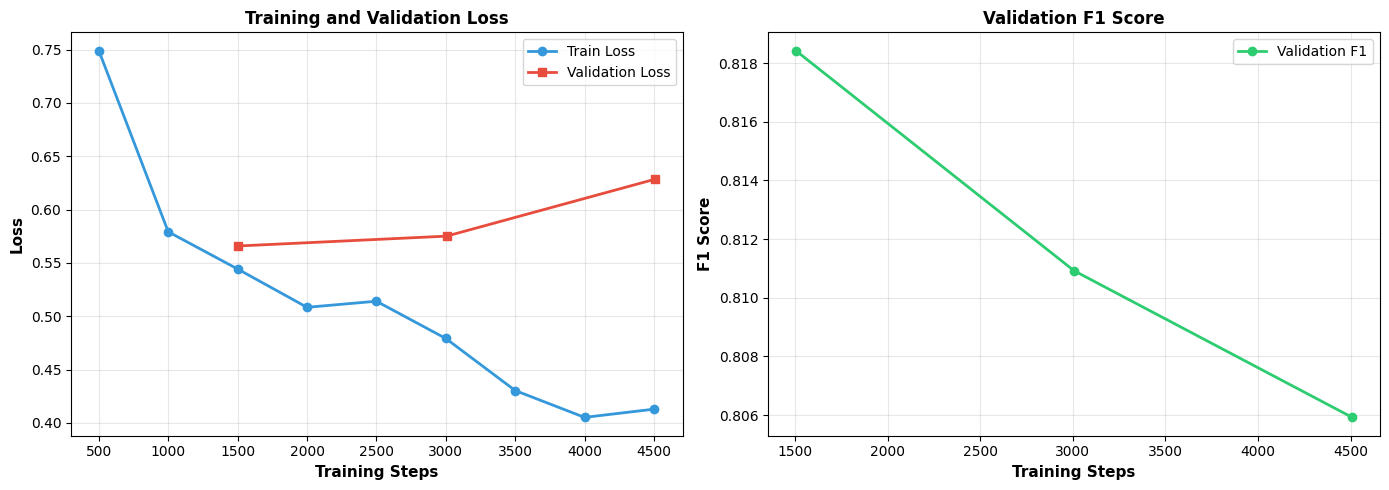

In [28]:
# Extract training history
log_history = trainer.state.log_history

# Separate train and eval logs
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Extract metrics
train_loss = [log['loss'] for log in train_logs]
train_steps = [log['step'] for log in train_logs]

eval_loss = [log['eval_loss'] for log in eval_logs]
eval_f1 = [log['eval_f1'] for log in eval_logs]
eval_steps = [log['step'] for log in eval_logs]

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(train_steps, train_loss, label='Train Loss', color='#3498db', linewidth=2, marker='o')
ax1.plot(eval_steps, eval_loss, label='Validation Loss', color='#e74c3c', linewidth=2, marker='s')
ax1.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# F1 score
ax2.plot(eval_steps, eval_f1, label='Validation F1', color='#2ecc71', linewidth=2, marker='o')
ax2.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax2.set_title('Validation F1 Score', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Model Evaluation

Evaluate the trained model on the test set.

In [39]:
# Evaluate on test set
print("Evaluating on test set...\n")
test_results = trainer.evaluate(tokenized_test)

print("Test Set Results:")
print(f"  Loss: {test_results.get('eval_loss', test_results.get('loss', 0.0)):.4f}")
print(f"  Accuracy: {test_results.get('eval_accuracy', test_results.get('accuracy', 0.0)):.4f}")
print(f"  Precision (weighted): {test_results.get('eval_precision_weighted', test_results.get('precision_weighted', 0.0)):.4f}")
print(f"  Recall (weighted): {test_results.get('eval_recall_weighted', test_results.get('recall_weighted', 0.0)):.4f}")
print(f"  F1 (weighted): {test_results.get('eval_f1_weighted', test_results.get('f1_weighted', test_results.get('f1', 0.0))):.4f}")
print(f"  F1 (macro): {test_results.get('eval_f1_macro', test_results.get('f1_macro', 0.0)):.4f}")

Evaluating on test set...



Test Set Results:
  Loss: 0.5401
  Accuracy: 0.0000
  Precision (weighted): 0.0000
  Recall (weighted): 0.0000
  F1 (weighted): 0.0000
  F1 (macro): 0.0000


In [40]:
# Get predictions
predictions_output = trainer.predict(tokenized_test)
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# Get probabilities
probabilities = torch.nn.functional.softmax(
    torch.tensor(predictions_output.predictions),
    dim=-1
).numpy()

print(f"✓ Generated predictions for {len(predictions)} samples")

✓ Generated predictions for 10304 samples


In [41]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(
    true_labels,
    predictions,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))


Classification Report:

              precision    recall  f1-score   support

    Negative     0.5835    0.6497    0.6149      1516
     Neutral     0.8824    0.7704    0.8226      3018
    Positive     0.8642    0.8958    0.8798      5770

    accuracy                         0.8229     10304
   macro avg     0.7767    0.7720    0.7724     10304
weighted avg     0.8282    0.8229    0.8240     10304



## 14. Confusion Matrix

Visualize model performance across classes.

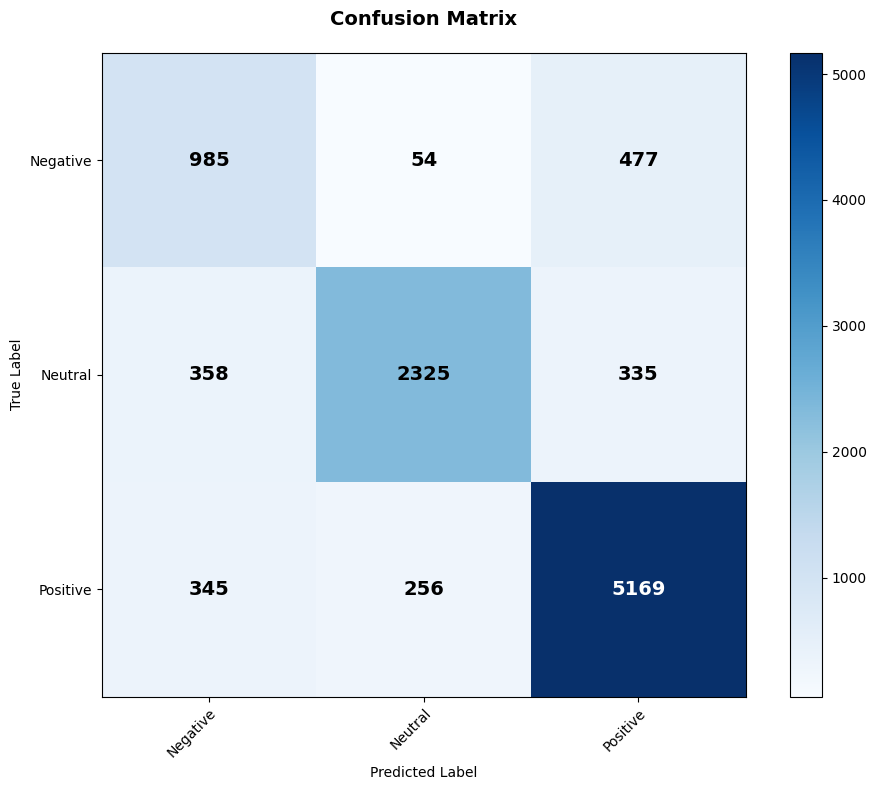

In [42]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

# Set ticks and labels
class_names = ['Negative', 'Neutral', 'Positive']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names,
       yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./assets/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 15. Example Predictions

Examine model predictions on test samples.

In [43]:
# Create predictions dataframe
predictions_df = test_df.copy().reset_index(drop=True)
predictions_df['predicted_label'] = predictions
predictions_df['true_label_name'] = predictions_df['label'].map(id2label)
predictions_df['predicted_label_name'] = predictions_df['predicted_label'].map(id2label)
predictions_df['confidence'] = np.max(probabilities, axis=-1)
predictions_df['correct'] = predictions_df['label'] == predictions_df['predicted_label']

# Add individual class probabilities
for i, label_name in id2label.items():
    predictions_df[f'prob_{label_name}'] = probabilities[:, i]

print(f"✓ Created predictions dataframe with {len(predictions_df)} samples")

✓ Created predictions dataframe with 10304 samples


In [44]:
# Show sample predictions
sample_predictions = predictions_df.head(20)[[
    'cleaned_text',
    'true_label_name',
    'predicted_label_name',
    'confidence',
    'correct'
]]

print("Sample Predictions (First 20):\n")
pd.set_option('display.max_colwidth', 60)
print(sample_predictions.to_string(index=False))
pd.reset_option('display.max_colwidth')

Sample Predictions (First 20):

                                                                                                                                                                                                                                                                                                     cleaned_text true_label_name predicted_label_name  confidence  correct
                                                                                                                                                                                                                     “تقييم” الموقع فقط المكاناري بان المكان يحتاج الي تغيير جذري لان المباني قديمه نوعا ما وشكرا        positive             positive    0.846399     True
                                                                                                                                                    ضعيف سوء التعامل من موضف الاستقبالعدم مراعات المتطلبات الشخصيه غير مناسب للعوايل المحترمه لت

In [45]:
# Analyze prediction quality
accuracy = (predictions_df['correct'].sum() / len(predictions_df)) * 100
avg_confidence = predictions_df['confidence'].mean()
correct_avg_conf = predictions_df[predictions_df['correct']]['confidence'].mean()
incorrect_avg_conf = predictions_df[~predictions_df['correct']]['confidence'].mean()

print(f"\nPrediction Analysis:")
print(f"  Accuracy: {accuracy:.2f}%")
print(f"  Average confidence: {avg_confidence:.4f}")
print(f"  Avg confidence (correct): {correct_avg_conf:.4f}")
print(f"  Avg confidence (incorrect): {incorrect_avg_conf:.4f}")


Prediction Analysis:
  Accuracy: 82.29%
  Average confidence: 0.8210
  Avg confidence (correct): 0.8550
  Avg confidence (incorrect): 0.6628


## 16. Save Model and Artifacts

Save the trained model, tokenizer, and evaluation results.

In [46]:
# Save model and tokenizer
print("Saving model and tokenizer...")

model.save_pretrained('./final_model')
tokenizer.save_pretrained('./final_model')

print("✓ Model and tokenizer saved to ./final_model")

Saving model and tokenizer...
✓ Model and tokenizer saved to ./final_model


In [47]:
# Save label mapping
label_map = {
    'id2label': id2label,
    'label2id': label2id
}

with open('./final_model/label_map.json', 'w', encoding='utf-8') as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print("✓ Label mapping saved to ./final_model/label_map.json")

✓ Label mapping saved to ./final_model/label_map.json


In [49]:
import os, json

os.makedirs("./assets", exist_ok=True)

def _m(d, *keys, default=0.0):
    for k in keys:
        if k in d and d[k] is not None:
            return float(d[k])
    return float(default)

metrics = {
    "test_loss": _m(test_results, "eval_loss", "loss", default=0.0),

    "test_accuracy": _m(test_results, "eval_accuracy", "accuracy", default=0.0),

    "test_precision_weighted": _m(test_results, "eval_precision_weighted", "precision_weighted", default=0.0),
    "test_recall_weighted": _m(test_results, "eval_recall_weighted", "recall_weighted", default=0.0),
    "test_f1_weighted": _m(test_results, "eval_f1_weighted", "f1_weighted", "f1", default=0.0),

    "test_precision_macro": _m(test_results, "eval_precision_macro", "precision_macro", default=0.0),
    "test_recall_macro": _m(test_results, "eval_recall_macro", "recall_macro", default=0.0),
    "test_f1_macro": _m(test_results, "eval_f1_macro", "f1_macro", default=0.0),

    "confusion_matrix": cm.tolist() if "cm" in globals() else None,

    "training_params": {
        "model": MODEL_NAME,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "warmup_ratio": WARMUP_RATIO,
        "weight_decay": WEIGHT_DECAY,
        "max_length": MAX_LENGTH,
        "random_seed": SEED
    }
}

with open("./assets/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print("✓ Metrics saved to ./assets/metrics.json")
print("Saved keys:", list(metrics.keys()))

✓ Metrics saved to ./assets/metrics.json
Saved keys: ['test_loss', 'test_accuracy', 'test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'confusion_matrix', 'training_params']


In [50]:
# Save sample predictions
predictions_df.head(50).to_csv('./assets/sample_predictions.csv', index=False, encoding='utf-8-sig')

print("✓ Sample predictions saved to ./assets/sample_predictions.csv")

✓ Sample predictions saved to ./assets/sample_predictions.csv


In [51]:
import os
import zipfile

model_dir = "./final_model"
zip_path = "./final_model.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(model_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, model_dir)
            zipf.write(file_path, arcname)

zip_path

'./final_model.zip'

## 17. Summary

**Training Complete!**

### Key Results:
- Model trained on Arabic sentiment analysis (3 classes)
- Test accuracy and metrics computed
- All artifacts saved to `./final_model` and `./assets`

### Saved Files:
- `./final_model/`: Trained model and tokenizer
- `./assets/metrics.json`: Evaluation metrics
- `./assets/confusion_matrix.png`: Confusion matrix visualization
- `./assets/training_curves.png`: Training progress plots
- `./assets/class_distribution.png`: Dataset distribution
- `./assets/sample_predictions.csv`: Example predictions

### Next Steps:
Download the `final_model` folder and use it with the Streamlit app locally:
```bash
streamlit run app.py
```